# Projeto Controle Fuzzy PD para Quadricópteros

In [159]:
#!pip install -U scikit-fuzzy

In [160]:
import re                       # Suporte para expressões regulares.
import itertools                # Suporte para iterações em arrays.
import numpy as np              # Suporte para arrays e operações matemáticas.
import pandas as pd             # Suporte para manipulação de DataFrames.
import skfuzzy as fuzzy         # Suporte para operação com Lógica Fuzzy.
from tabulate import tabulate   # Suporte para manipulação de Tabelas.
import skfuzzy.control as ctrl  # Suporte para manipulação de Sistemas Fuzzy.
import matplotlib.pyplot as plt # Suporte para visualização de gráficos.
import paho.mqtt.client as mqtt
import json
import time

# Definição do universo das variáveis

Erro (𝑒):

Muito Pequeno (MP): O erro é muito pequeno, próximo do setPoint.

Pequeno (P): O erro é pequeno, distância pequena do setPoint.

Médio (M): O erro está moderado, distância intermediária do setPoint.

Grande (G): O erro é grande, distância alta do setPoint.

Muito Grande (MG): O erro é muito grande, muito longe do setPoint.


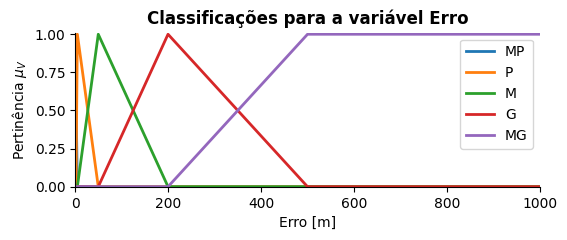

In [180]:
# Definição da variável Antecedente Erro 0:1000 m
Erro = ctrl.Antecedent(universe=np.arange(0, 1001, 1), label='Erro')

# Classificações de Erro
Erro['MP'] = fuzzy.trimf(Erro.universe, [0, 0, 5])
Erro['P'] = fuzzy.trimf(Erro.universe, [2, 5, 50])
Erro['M'] = fuzzy.trimf(Erro.universe, [5, 50, 200])
Erro['G'] = fuzzy.trimf(Erro.universe, [50, 200, 500])
Erro['MG'] = fuzzy.trapmf(Erro.universe, [200, 500, 1000, 1000])

Erro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f'{Erro.label} [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$')
plt.title(f'Classificações para a variável {Erro.label}', fontweight='bold'); plt.legend(loc='upper right')

Variação do Erro (Δ𝑒):

Muito Negativo (MN): A variacao do erro é muito negativa.

Negativo (N): A variacao do erro é negativo.

Médio (M): A variacao do erro é intermediária.

Positivo (P): A variacao do erro é positiva.

Muito Positivo (MP): A variacao do erro é muito positiva.

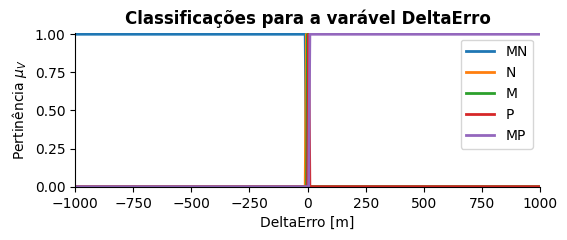

In [181]:
# Definição da variável Antecedente DeltaErro -1000:1000 m
DeltaErro = ctrl.Antecedent(universe=np.arange(-1000, 1001, 1), label='DeltaErro')

# Classificações de DeltaErro
DeltaErro['MN'] = fuzzy.trapmf(DeltaErro.universe, [-1000, -1000, -10, -5])
DeltaErro['N'] = fuzzy.trimf(DeltaErro.universe, [-10, -5, 0])
DeltaErro['M'] = fuzzy.trimf(DeltaErro.universe, [-4, 0, 4])
DeltaErro['P'] = fuzzy.trimf(DeltaErro.universe, [0, 5, 10])
DeltaErro['MP'] = fuzzy.trapmf(DeltaErro.universe, [5, 10, 1000, 1000])

DeltaErro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='DeltaErro [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {DeltaErro.label}', fontweight='bold'); plt.legend(loc='upper right');

Potência do Motor (𝑃𝑀𝑜𝑡𝑜𝑟):

Muito Baixa (MB): Potência muito baixa.

Baixa (B): Potência baixa.

Média (M): Potência média.

Alta (A): Potência alta.

Muito Alta (MA): Potência muito alta.


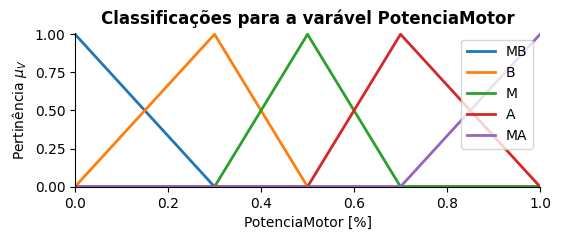

In [182]:
# Definição da variável Consequente PotenciaMotor 0:1
PotenciaMotor = ctrl.Consequent(universe=np.arange(0, 1.01, 0.01), label='PotenciaMotor')

# Classificações de PotenciaMotor
PotenciaMotor['MB'] = fuzzy.trimf(PotenciaMotor.universe, [0, 0, 0.3])
PotenciaMotor['B'] = fuzzy.trimf(PotenciaMotor.universe, [0, 0.3, 0.5])
PotenciaMotor['M'] = fuzzy.trimf(PotenciaMotor.universe, [0.3, 0.5, 0.7])
PotenciaMotor['A'] = fuzzy.trimf(PotenciaMotor.universe, [0.5, 0.7, 1.0])
PotenciaMotor['MA'] = fuzzy.trimf(PotenciaMotor.universe, [0.7, 1.0, 1.0])

PotenciaMotor.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='PotenciaMotor [%]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {PotenciaMotor.label}', fontweight='bold'); plt.legend(loc='upper right');

# Base de Regras

In [183]:
# Base de Regras
BaseRegras = [
    ctrl.Rule(Erro['MP'] & DeltaErro['MN'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['N'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['M'], PotenciaMotor['B']),
    ctrl.Rule(Erro['MP'] & DeltaErro['P'], PotenciaMotor['M']),
    ctrl.Rule(Erro['MP'] & DeltaErro['MP'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['P'] & DeltaErro['MN'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['N'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['M'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['P'], PotenciaMotor['M']),
    ctrl.Rule(Erro['P'] & DeltaErro['MP'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['M'] & DeltaErro['MN'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['N'], PotenciaMotor['B']),
    ctrl.Rule(Erro['M'] & DeltaErro['M'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['P'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['MP'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['G'] & DeltaErro['MN'], PotenciaMotor['A']),
    ctrl.Rule(Erro['G'] & DeltaErro['N'], PotenciaMotor['M']),
    ctrl.Rule(Erro['G'] & DeltaErro['M'], PotenciaMotor['M']),
    ctrl.Rule(Erro['G'] & DeltaErro['P'], PotenciaMotor['A']),
    ctrl.Rule(Erro['G'] & DeltaErro['MP'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['MG'] & DeltaErro['MN'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['MG'] & DeltaErro['N'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['M'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['P'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['MP'], PotenciaMotor['MA'])
]



In [184]:
ciano = '\033[96m'  # Define a cor azul-ciano

tabela = []
for erro in Erro.terms:  # Itera sobre os termos de classificação da variável Erro.
    for deltaErro in DeltaErro.terms:  # Itera sobre os termos de classificação da variável DeltaErro.
        for regra in BaseRegras:  # Itera sobre todas as regras da base.
            antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
            consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

            # Encontra os classificadores (termos fuzzy) no texto da regra.
            classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
            if erro == classificacoes[0] and deltaErro == classificacoes[1]:
                tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
                break

# Cria um DataFrame com os dados da tabela.
df = pd.DataFrame(tabela, columns=[Erro.label, DeltaErro.label, PotenciaMotor.label])

# Cria a tabela pivô para organização visual.
pivotTable = pd.DataFrame(df.pivot(index=DeltaErro.label, columns=Erro.label, values=PotenciaMotor.label)
                          .reindex(index=DeltaErro.terms, columns=Erro.terms))

# Nomeia o índice e aplica formatação colorida.
pivotTable.index.name = f"{ciano}E\033[0m"

# Exibe a tabela formatada.
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'), end='\n\n')


╒═════╤══════╤═════╤═════╤═════╤══════╕
│  E  │  MP  │  P  │  M  │  G  │  MG  │
╞═════╪══════╪═════╪═════╪═════╪══════╡
│ MN  │  MB  │  B  │  M  │  A  │  MA  │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  N  │  MB  │  B  │  B  │  M  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  M  │  B   │  B  │  M  │  M  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  P  │  M   │  M  │  M  │  A  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│ MP  │  A   │  A  │  A  │  A  │  MA  │
╘═════╧══════╧═════╧═════╧═════╧══════╛



# Definindo uma regra qualquer e observando como ela é interpretada.


Graus de pertinência para Erro:
  - G: 1.00

Graus de pertinência para DeltaErro:
  - M: 0.50
  - P: 0.40

Classificações da variável de saída (PotenciaMotor):
  - M: 0.36
  - A: 0.64

Valor final da PotenciaMotor: 0.63


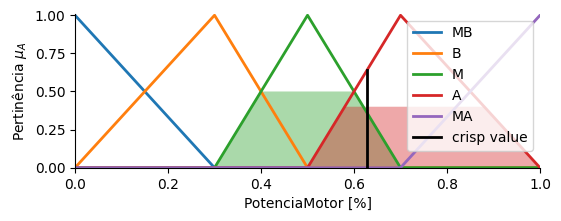

In [186]:
# Configurando o sistema de controle
ControleErro = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

# Definindo entradas para Erro e DeltaErro
ControleErro.input[Erro.label] = 200  # valor desejado para Erro
ControleErro.input[DeltaErro.label] = 2  # valor desejado para DeltaErro

# Realiza o cálculo do sistema fuzzy
ControleErro.compute()

# Graus de pertinência para a variável Erro
print(f"\nGraus de pertinência para {Erro.label}:")
ativacaoErro = []  # Lista de regiões ativadas para o Erro
for erro_nome, erro_mf in Erro.terms.items():
    uV = fuzzy.interp_membership(Erro.universe, erro_mf.mf, ControleErro._get_inputs()[Erro.label])
    if uV > 0:
        print(f"  - {erro_nome}: {uV:.2f}")
        ativacaoErro.append(erro_nome)

# Graus de pertinência para a variável DeltaErro
print(f"\nGraus de pertinência para {DeltaErro.label}:")
ativacaoDeltaErro = []  # Lista de regiões ativadas para o DeltaErro
for delta_nome, delta_mf in DeltaErro.terms.items():
    uI = fuzzy.interp_membership(DeltaErro.universe, delta_mf.mf, ControleErro._get_inputs()[DeltaErro.label])
    if uI > 0:
        print(f"  - {delta_nome}: {uI:.2f}")
        ativacaoDeltaErro.append(delta_nome)

# Valor da variável de saída (PotenciaMotor)
print(f"\nClassificações da variável de saída ({PotenciaMotor.label}):")
for termo_nome, termo_mf in PotenciaMotor.terms.items():
    uA = fuzzy.interp_membership(PotenciaMotor.universe, termo_mf.mf, ControleErro.output[PotenciaMotor.label])
    if uA > 0:
        print(f"  - {termo_nome}: {uA:.2f}")

# Exibição gráfica da saída
PotenciaMotor.view(sim=ControleErro)
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f"{PotenciaMotor.label} [%]"); axes.set_ylabel(ylabel=r"Pertinência $\mu_{A}$")
plt.legend(loc='upper right')

# Resultado final da Potência do Motor
print(f"\nValor final da {PotenciaMotor.label}: {ControleErro.output[PotenciaMotor.label]:.2f}")


### Resultados para setpoint = 200 m e posição_atual = 800 m

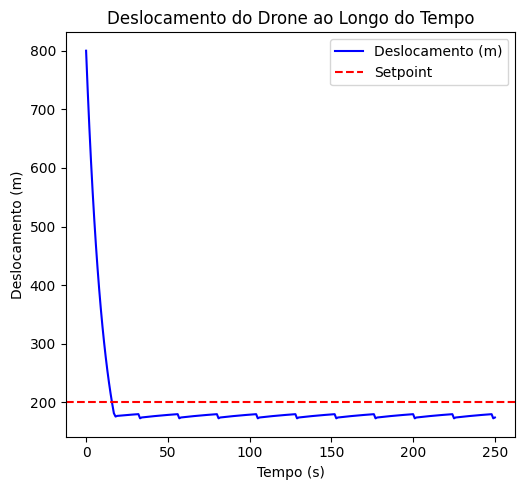

In [187]:
# Criar o sistema de controle fuzzy
ControleErro = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

# Definir parâmetros do sistema
setpoint = 200  # Altitude desejada (em metros)
posicao_atual = 800  # posição atual do drone, em metros
tempo = 250  # Tempo de simulação (em segundos)

# Parâmetro do sistema fuzzy
U_max = 4  # Velocidade máxima de descida (m/s)

# Valores para armazenar deslocamentos e erros
deslocamentos = [posicao_atual]
erros = [setpoint - posicao_atual]

# Loop para simulação
for t in range(1, tempo + 1):
    # Calcular o erro
    erro_atual = setpoint - posicao_atual
    erros.append(erro_atual)

    # Calcular a taxa de variação do erro
    delta_erro_atual = (erros[-1] - erros[-2])

    # Configurar entradas do sistema fuzzy
    ControleErro.input['Erro'] = erro_atual
    ControleErro.input['DeltaErro'] = delta_erro_atual

    # Realizar o cálculo fuzzy
    ControleErro.compute()

    # Obter a saída defuzzyficada (potência do motor)
    P_Motor = ControleErro.output['PotenciaMotor']

    # Divisão da potência entre os motores
    P_H13 = P_Motor
    P_H24 = P_Motor

    if erro_atual < 4:
        P_H13, P_H24 = [0.35, 0.35]

    if erro_atual < 4:
        FA = 0.9
    elif erro_atual < 10:
        FA = 0.92
    elif erro_atual < 20:
        FA = 0.94
    else:
        FA = 0.98

    # Atualizar o deslocamento com a função de transferência
    d_t = FA * posicao_atual * 1.01398 + (0.5 * (U_max * P_H13 + U_max * P_H24))
    deslocamentos.append(d_t)

    # Atualizar o deslocamento anterior
    posicao_atual = d_t

# Gráficos
plt.figure(figsize=(10, 5))

# Gráfico do deslocamento
plt.subplot(1, 2, 1)
plt.plot(range(len(deslocamentos)), deslocamentos, label='Deslocamento (m)', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label='Setpoint')
plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')
plt.title('Deslocamento do Drone ao Longo do Tempo')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#### Enviar os dados de tempo, setpoint e posição para o Node-RED.

In [194]:
# Configurações do Broker MQTT
broker = "broker.hivemq.com"
port = 1883
topic = "drone/controle"

# Conexão com o broker MQTT
client = mqtt.Client()
client.connect(broker, port)

# Variáveis do sistema
setpoint = 200  # Setpoint inicial
posicao_inicial = 800  # Posição inicial do drone
tempo_simulacao = 25  # Tempo de simulação (segundos)

# Publica os dados no tópico MQTT
def publicar_dados(setpoint, posicao_atual, tempo):
    payload = {
        "tempo": tempo,
        "setpoint": setpoint,
        "posicao_atual": posicao_atual,
    }
    client.publish(topic, json.dumps(payload))
    print(f"Publicado: {json.dumps(payload)}")

# Simulação do drone
def simular_drone(setpoint, posicao_inicial, tempo_simulacao):
    U_max = 4  # Velocidade máxima de descida (m/s)

    posicao_atual = posicao_inicial
    deslocamentos = [posicao_atual]

    for t in range(1, tempo_simulacao + 1):

        # Calcular o erro
        erro_atual = setpoint - posicao_atual
        erros.append(erro_atual)

        # Calcular a taxa de variação do erro
        delta_erro_atual = (erros[-1] - erros[-2])

        # Configurar entradas do sistema fuzzy
        ControleErro.input['Erro'] = erro_atual
        ControleErro.input['DeltaErro'] = delta_erro_atual

        # Realizar o cálculo fuzzy
        ControleErro.compute()

        # Obter a saída defuzzyficada (potência do motor)
        P_Motor = ControleErro.output['PotenciaMotor']

        # Divisão da potência entre os motores
        P_H13 = P_Motor
        P_H24 = P_Motor

        if erro_atual < 4:
            P_H13, P_H24 = [0.35, 0.35]

        if erro_atual < 4:
            FA = 0.9
        elif erro_atual < 10:
            FA = 0.92
        elif erro_atual < 20:
            FA = 0.94
        else:
            FA = 0.98

        # Atualizar o deslocamento com a função de transferência
        posicao_atual = FA * posicao_atual * 1.01398 + (0.5 * (U_max * P_H13 + U_max * P_H24))
        deslocamentos.append(posicao_atual)

        # Publica os dados no broker MQTT
        publicar_dados(setpoint, posicao_atual, t)

        # Espera o próximo intervalo
        time.sleep(1)

    return deslocamentos

# Função para alterar o setpoint
def alterar_setpoint(novo_setpoint):
    global setpoint
    setpoint = novo_setpoint
    print(f"Setpoint alterado para: {setpoint}")

# Função para alterar a posição inicial
def alterar_posicao_inicial(nova_posicao):
    global posicao_inicial
    posicao_inicial = nova_posicao
    print(f"Posição inicial alterada para: {posicao_inicial}")

# Função para definir o setpoint como zero (home)
def definir_home():
    global setpoint
    setpoint = 0
    print("Setpoint zerado (home).")

# Exemplo de execução
if __name__ == "__main__":
    print("Iniciando simulação...")

    # Alterar o setpoint ou posição inicial antes da simulação
    alterar_setpoint(300)
    alterar_posicao_inicial(900)

    # Simular o drone
    deslocamentos = simular_drone(setpoint, posicao_inicial, tempo_simulacao)

    # Definir o setpoint para home
    definir_home()


C:\Users\leona\AppData\Local\Temp\ipykernel_13188\589177585.py:7: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Iniciando simulação...
Setpoint alterado para: 300
Posição inicial alterada para: 900
Publicado: {"tempo": 1, "setpoint": 300, "posicao_atual": 822.7238000000001}
Publicado: {"tempo": 2, "setpoint": 300, "posicao_atual": 752.2029308516002}
Publicado: {"tempo": 3, "setpoint": 300, "posicao_atual": 687.846855042415}
Publicado: {"tempo": 4, "setpoint": 300, "posicao_atual": 629.1166586683172}
Publicado: {"tempo": 5, "setpoint": 300, "posicao_atual": 575.5205386008503}
Publicado: {"tempo": 6, "setpoint": 300, "posicao_atual": 526.6096841574412}
Publicado: {"tempo": 7, "setpoint": 300, "posicao_atual": 481.97451878776604}
Publicado: {"tempo": 8, "setpoint": 300, "posicao_atual": 441.24127030437717}
Publicado: {"tempo": 9, "setpoint": 300, "posicao_atual": 404.06884093690917}
Publicado: {"tempo": 10, "setpoint": 300, "posicao_atual": 370.14595099988645}
Publicado: {"tempo": 11, "setpoint": 300, "posicao_atual": 339.1885322553784}
Publicado: {"tempo": 12, "setpoint": 300, "posicao_atual": 310